In [1]:
import ee

In [6]:
pip install geemap

Note: you may need to restart the kernel to use updated packages.


In [8]:
import ee

# Authenticate the Earth Engine account
ee.Authenticate()

# Initialize the Earth Engine API
ee.Initialize()

Enter verification code: 4/1AdLIrYdXb2ivCr5OeOFk6deOzK0rbDwoD5xeDBNGNmEnISyJmk_MPZVIYQk

Successfully saved authorization token.


In [ ]:
# Initialize the Earth Engine API


In [9]:
import ee
import json
import datetime
import matplotlib.pyplot as plt
import pandas as pd


In [10]:
geojson = json.loads(open(r"C:\Users\RISHIN RAJESH\Downloads\state.geojson").read())


In [27]:
# Define the time range
start_date = '2018-01-01'
end_date = '2018-12-31'


In [28]:
geojson

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'ST_NM': 'Kerala', 'orig_ogc_f': 15},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[74.99575065337001, 12.79226798218167],
      [75.00006111023208, 12.787766069548525],
      [75.00372737012208, 12.789910829421274],
      [75.00507209669996, 12.789785616812821],
      [75.00392401947795, 12.777833704162163],
      [75.00504236691177, 12.773630454581848],
      [75.00762852034, 12.769399110180814],
      [75.00845422478272, 12.764735311485481],
      [75.00694545107177, 12.761364391653387],
      [75.00409989899123, 12.758290963956881],
      [75.00007171233972, 12.755846374610542],
      [74.99508430609592, 12.749135386189153],
      [74.99155573870644, 12.742459449743876],
      [74.98964342300565, 12.741586946380494],
      [74.9858281292648, 12.74276642253244],
      [74.98418397521033, 12.740223657795639],

In [29]:
# Convert the GeoJSON to an Earth Engine object
region = ee.Geometry(geojson['features'][0]['geometry'])

In [30]:
# Load the JRC Global Surface Water dataset
dataset = ee.ImageCollection("JRC/GSW1_3/MonthlyHistory")\
          .filterBounds(region)\
          .filterDate(start_date, end_date)\
          .select('water')

In [31]:
# Function to calculate water area
def calculate_water_area(image):
    water = image.eq(2)  # Permanent water
    water_area = water.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=30,
        maxPixels=1e9
    )
    return image.set({'water_area': water_area.get('water')})

In [32]:
# Apply the function to each image in the collection
water_area_collection = dataset.map(calculate_water_area)

In [33]:
# Extract the water area time series
def extract_values(image):
    date = image.date().format('YYYY-MM-dd')
    water_area = ee.Number(image.get('water_area'))
    return ee.Feature(None, {'date': date, 'water_area': water_area})


In [34]:
# Create a feature collection with the extracted values
water_area_features = water_area_collection.map(extract_values)
water_area_list = water_area_features.getInfo()['features']


In [35]:
# Convert to pandas DataFrame for plotting
dates = [feature['properties']['date'] for feature in water_area_list]
areas = [feature['properties']['water_area'] for feature in water_area_list]

In [36]:
data = pd.DataFrame({'Date': pd.to_datetime(dates), 'Water Area (m^2)': areas})
data = data.sort_values(by='Date')

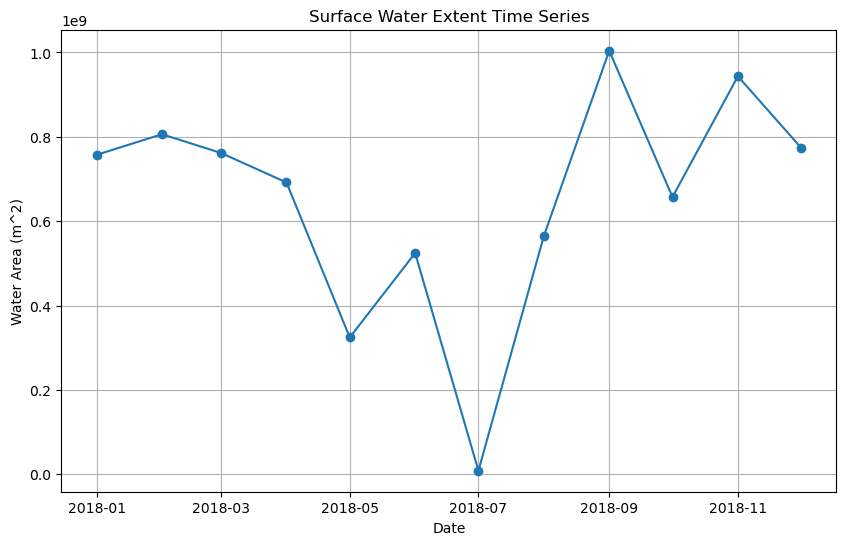

In [37]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Water Area (m^2)'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Water Area (m^2)')
plt.title('Surface Water Extent Time Series')
plt.grid(True)
plt.savefig('water_extent_time_series.png')
plt.show()
